# 1d2v Vlasov-Maxwell solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fembase as fem
import picbase as pic
from bsplines import Bspline
from scipy.integrate import fixed_quad
from scipy import integrate

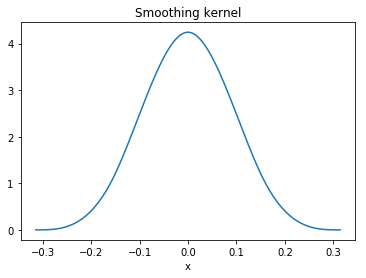

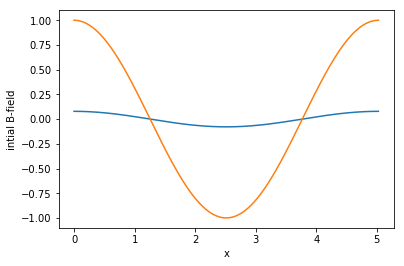

In [15]:
# Parameters:

# wavenumber of perturbations
k = 1.25

# domain boundaries
a_boundary = 0
b_boundary = 2*np.pi/k
Lx = b_boundary - a_boundary

# number of elements
Nel = 32
el_b = np.linspace(a_boundary, b_boundary, Nel + 1)

# element size
dx = (b_boundary - a_boundary)/Nel

# degree of basis functions in V0
degree = 3

# degree of B-spline smoothing kernel
p = 3


# number of particles for simulationi
Np = np.int(5e4)



# create and plot smoothing kernel
a_kernel = -(p + 1)/2*dx
b_kernel = +(p + 1)/2*dx
nodes = np.linspace(a_kernel,b_kernel,p + 2)
le = np.linspace(a_kernel - p*dx,a_kernel - dx,p)
ri = np.linspace(b_kernel + dx,b_kernel + p*dx,p)

T = np.array(list(le)  + list(nodes) + list(ri))
bsp_S = Bspline(T,p)

kernel = lambda x: 1/dx*bsp_S(x,p)
    
nx = 200
supp = np.linspace(a_kernel,b_kernel,nx)
y = kernel(supp)

plt.plot(supp,y)
plt.xlabel('x')
plt.title('Smoothing kernel')


# create Lagrange shape functions in V1 and V0 and compute global matrices M0 and M1
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
Nbase_0, mass_0 = fem.lag_assemb(el_b, shapefun.mass0, shapefun.stiff0, bcs = 2)[1:3]
Nbase_1, mass_1 = fem.lag_assemb(el_b, shapefun.mass1, shapefun.stiff1, basis = 2, bcs = 2)[1:3]


# initialize B-field, compute initial coefficients by L2-projection on the basis and check result
beta = 1.

B_0 = lambda x: beta*np.cos(k*x)
bbar = fem.lag_L2prod(B_0, shapefun.chi, el_b, basis = 2)[2]

b = np.linalg.solve(mass_1,bbar)

plt.figure()
fun = fem.lag_fun(b, shapefun.chi, el_b, basis = 2)[2]
x2 = np.linspace(a_boundary, b_boundary, 200)
plt.plot(x2, fun(x2))
plt.plot(x2, B_0(x2))
plt.xlabel('x')
plt.ylabel('intial B-field')

# assemble gradient matrix
grad1 = np.ones(Nbase_0)
grad2 = -np.ones(Nbase_0 - 1)
Grad = np.diag(grad1) + np.diag(grad2, -1)
Grad = np.append(Grad, [np.zeros(Nbase_0)], axis = 0)
Grad[-1, -1] = -1

# initialize distribution function and define sampling distribution for initial markers
sigma_1 = 0.02/np.sqrt(2)
sigma_2 = np.sqrt(12)*sigma_1
alpha = 0

f0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2))*(1 + alpha*np.cos(k*x))
g0 = lambda x,vx,vy: 1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2))*1/Lx

# create particles and compute weights
particles = np.zeros((Np,4))

particles[:, 0] = np.random.rand(Np)*Lx
particles[:, 1] = np.random.randn(Np)*sigma_1
particles[:, 2] = np.random.randn(Np)*sigma_2

particles[:, 3] = 1/Np*f0(particles[:, 0],particles[:, 1], particles[:, 2])/g0(particles[:, 0],particles[:, 1], particles[:, 2])

In [16]:
shapefun.s

array([-1.        , -0.33333333,  0.33333333,  1.        ])

In [18]:
d = degree
xi = shapefun.s
glob_xi = np.zeros(Nel*d + 1)
# global knot vector
    
for ie in range(Nel):
    for il in range(d + 1):
            
        i = ie*d + il
        glob_xi[i] = el_b[ie] + (xi[il] + 1)/2*(el_b[ie + 1] - el_b[ie])

In [19]:
glob_xi

array([0.        , 0.05235988, 0.10471976, 0.15707963, 0.20943951,
       0.26179939, 0.31415927, 0.36651914, 0.41887902, 0.4712389 ,
       0.52359878, 0.57595865, 0.62831853, 0.68067841, 0.73303829,
       0.78539816, 0.83775804, 0.89011792, 0.9424778 , 0.99483767,
       1.04719755, 1.09955743, 1.15191731, 1.20427718, 1.25663706,
       1.30899694, 1.36135682, 1.41371669, 1.46607657, 1.51843645,
       1.57079633, 1.6231562 , 1.67551608, 1.72787596, 1.78023584,
       1.83259571, 1.88495559, 1.93731547, 1.98967535, 2.04203522,
       2.0943951 , 2.14675498, 2.19911486, 2.25147474, 2.30383461,
       2.35619449, 2.40855437, 2.46091425, 2.51327412, 2.565634  ,
       2.61799388, 2.67035376, 2.72271363, 2.77507351, 2.82743339,
       2.87979327, 2.93215314, 2.98451302, 3.0368729 , 3.08923278,
       3.14159265, 3.19395253, 3.24631241, 3.29867229, 3.35103216,
       3.40339204, 3.45575192, 3.5081118 , 3.56047167, 3.61283155,
       3.66519143, 3.71755131, 3.76991118, 3.82227106, 3.87463